In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import featureman.gen_data as man
from sklearn.cluster import SpectralClustering
import pickle
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
sae_dict = torch.load("sae_model_small_batch_2025-08-07_00-27-27.pth", map_location=device)
sae = man.BatchedSAE_Updated(input_dim=512, n_models=5, width_ratio=4).to(device)
sae.load_state_dict(sae_dict)

model_dict = torch.load("modular_arithmetic_model.pth", map_location=device)
model = man.OneLayerTransformer(p=113, d_model=128, nheads=4).to(device)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [3]:
torch.manual_seed(1337)
# generate combination of all inputs a and b range (113)
a = np.arange(113)
b = np.arange(113)
# generate inputs for the model
inputs = np.array([[a_i, 113, b_i, 114] for a_i in a for b_i in b])
inputs = torch.tensor(inputs).to(device)  # Add batch dimension
print(inputs.shape)
logits, activations = model(inputs, return_activations=True)
activations_data = activations[:, -1, :].detach()
batched_acts = activations_data.unsqueeze(0).repeat(5, 1, 1).to(device)
del model, model_dict
print(batched_acts.shape)

torch.Size([12769, 4])
torch.Size([5, 12769, 512])


In [4]:
decoder = sae.W_d[3].detach()
print(decoder.shape)
_, _, feat_acts, recons = sae(batched_acts)
features = feat_acts[3].detach()

torch.Size([2048, 512])


OutOfMemoryError: CUDA out of memory. Tried to allocate 998.00 MiB. GPU 0 has a total capacity of 7.77 GiB of which 326.69 MiB is free. Process 1777618 has 3.25 GiB memory in use. Including non-PyTorch memory, this process has 2.13 GiB memory in use. Of the allocated memory 1.57 GiB is allocated by PyTorch, and 414.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
recon_a = recons[3][:113].detach().cpu().numpy()

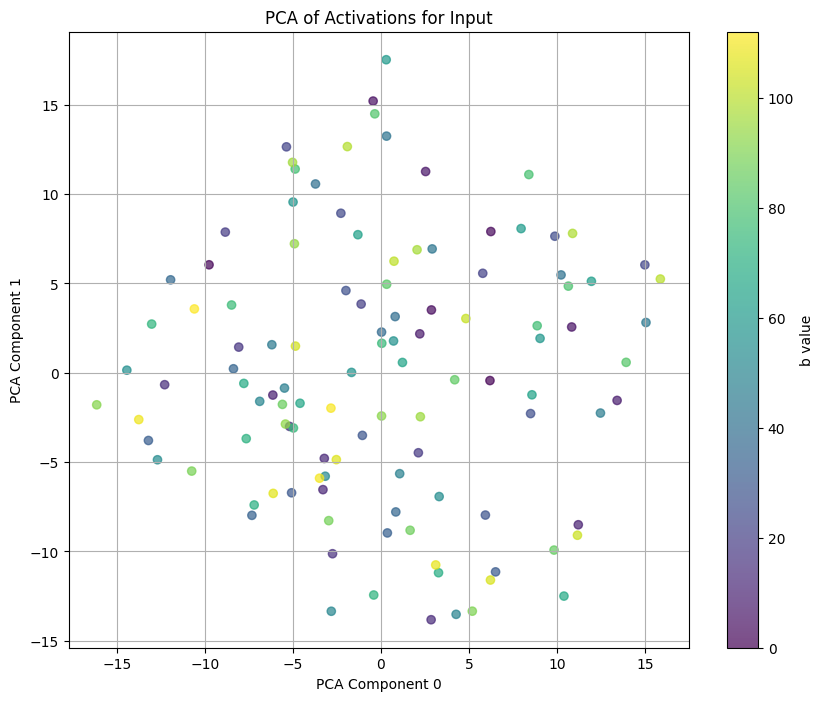

In [6]:
from sklearn.decomposition import PCA
# Perform PCA on the activations for input_a
pca = PCA()
pca_result = pca.fit_transform(recon_a)
# Visualize PCA result
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[: ,0][:], pca_result[:, 1][:], c=b[:], alpha=0.7, cmap='viridis')
plt.colorbar(label='b value')
plt.title(f'PCA of Activations for Input')
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.grid()
plt.show()

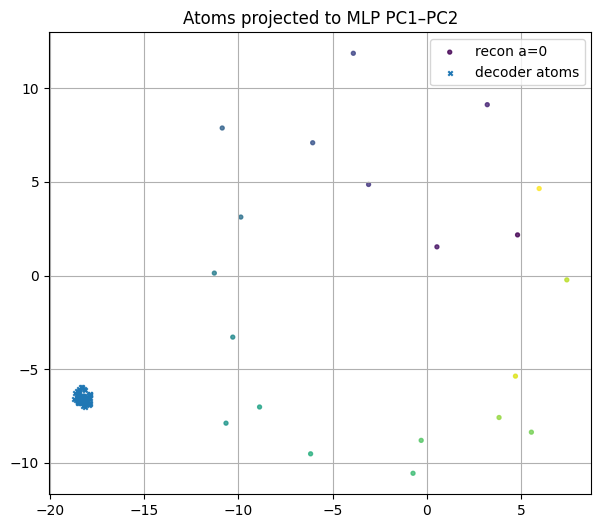

In [11]:
# 1) Fit PCA on raw a=0 activations (recommended)
mlp_a0 = batched_acts[3][:113].detach().cpu().numpy()   # (113, 512)
pca = PCA(n_components=2).fit(mlp_a0)

# 2) Plot your reconstructions in that basis (optional context)
pts2d = pca.transform(recon_a)                          # recon_a already (113, 512)

# 3) Get decoder atoms in (m, d) shape
dec = sae.W_d[3].detach().cpu().numpy()                 # either (m, d) or (d, m)
d = mlp_a0.shape[1]
atoms = dec if dec.shape[1] == d else dec.T             # atoms: (m, d)

# 4) Project atoms to PC1–PC2 (same centering as PCA)
atoms2d = (atoms - pca.mean_) @ pca.components_[:2].T   # (m, 2)

# 5) Visualize
plt.figure(figsize=(7,6))
plt.scatter(pts2d[:,0][:20], pts2d[:,1][:20], s=8, alpha=0.8, label='recon a=0', c=b[:20], cmap='viridis')
plt.scatter(atoms2d[:,0], atoms2d[:,1], s=10, marker='x', label='decoder atoms')
plt.legend(); plt.title("Atoms projected to MLP PC1–PC2"); plt.grid(True)
plt.show()


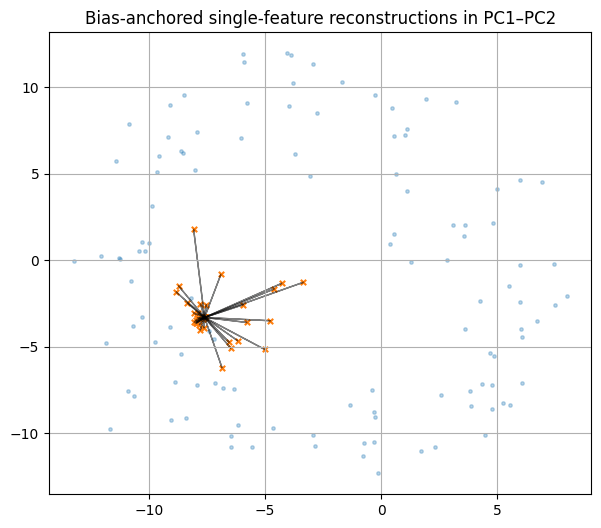

In [8]:
# Feature amplitudes on a=0 slice (choose a robust high percentile)
feat_slice = features[:113].detach().cpu().numpy()      # (113, m)
amps = np.percentile(feat_slice, 90, axis=0)            # (m,)

# Decoder bias (name may differ in your code: b_dec / b_d)
b_dec = sae.b_d[3].detach().cpu().numpy()             # (d,)

# Build one-feature recon prototypes: b_dec + amps_k * atom_k
protos = b_dec[None, :] + (amps[:, None] * atoms)       # (m, d)

# Project both anchor and prototypes
anchor2d = pca.transform(b_dec[None, :])                # (1, 2)
protos2d = pca.transform(protos)                        # (m, 2)

# (Optional) only show top-N most-used features to reduce clutter
usage = (feat_slice > 0).mean(axis=0)                   # (m,)
top = usage.argsort()[-64:]                             # top 64
plt.figure(figsize=(7,6))
plt.scatter(pts2d[:,0], pts2d[:,1], s=6, alpha=0.3)
plt.scatter(protos2d[top,0], protos2d[top,1], s=15, marker='x')
for i in top:
    plt.arrow(anchor2d[0,0], anchor2d[0,1],
              protos2d[i,0]-anchor2d[0,0],
              protos2d[i,1]-anchor2d[0,1],
              head_width=0.0, length_includes_head=True, alpha=0.5)
plt.title("Bias-anchored single-feature reconstructions in PC1–PC2")
plt.grid(True); plt.show()
